Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0006  1.0007  1.0003  1.0008  1.0006  1.0006  0.0002  
MAE (testset)     1.0004  1.0003  1.0001  1.0005  1.0004  1.0003  0.0001  
Fit time          0.41    0.42    0.36    0.35    0.35    0.38    0.03    
Test time         0.06    0.05    0.05    0.05    0.05    0.05    0.00    
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9374  0.9391  0.9384  0.9365  0.9307  0.9364  0.0030  
MAE (testset)     0.7388  0.7379  0.7405  0.7403  0.7328  0.7381  0.0028  
Fit time          0.40    0.42    0.39    0.35    0.39    0.39    0.02    
Test time         0.23    0.05    0.05    0.05    0.05    0.09    0.07    


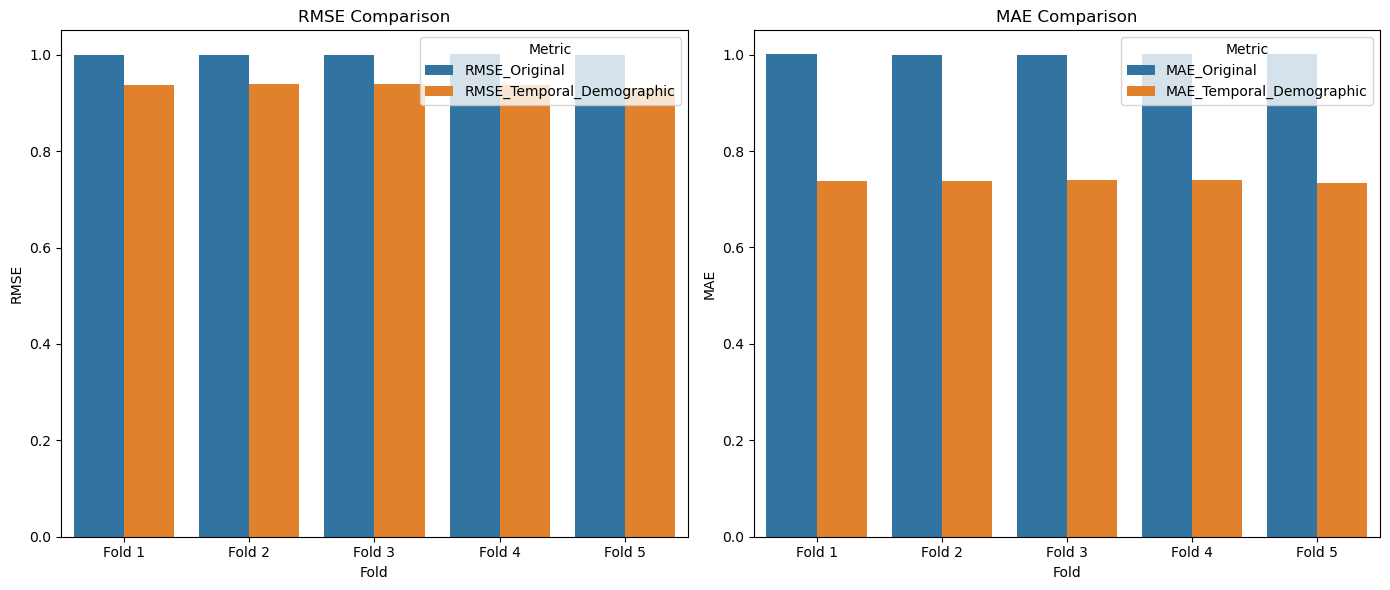

Mean RMSE without Temporal and Demographic Features: 1.0006
Mean RMSE with Temporal and Demographic Features: 0.9364
Mean MAE without Temporal and Demographic Features: 1.0003
Mean MAE with Temporal and Demographic Features: 0.7381


In [21]:
# Movie Recommendation System

# Import necessary libraries
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns

# Load ratings data
ratings_path = 'u.data'  
ratings = pd.read_csv(ratings_path, sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Load movies data
movies_path = 'u.item'  
movies = pd.read_csv(movies_path, sep='|', encoding='latin-1', header=None)
movies.columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + [f'genre_{i}' for i in range(19)]

# Load users data
users_path = 'u.user' 
users = pd.read_csv(users_path, sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

# Combine datasets into one DataFrame
data = pd.merge(pd.merge(ratings, movies, on='movie_id'), users, on='user_id')

# Convert timestamp to datetime and extract features
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['hour_of_day'] = data['timestamp'].dt.hour
data['day_of_week'] = data['day_of_week'] / 6.0  # Normalize day of week
data['hour_of_day'] = data['hour_of_day'] / 23.0  # Normalize hour of day

# One-hot encode demographic features
demographic_features = pd.get_dummies(data[['gender', 'occupation']])
combined_data = pd.concat([data[['user_id', 'movie_id', 'rating']], data[['day_of_week', 'hour_of_day']], demographic_features], axis=1)

# Calculate adjusted ratings with decay factor
current_time = data['timestamp'].max().timestamp()
decay_rate = 0.001 
data['weight'] = np.exp(-decay_rate * (current_time - data['timestamp'].astype(np.int64) / 1e9))
data['adjusted_rating'] = data['rating'] * data['weight']

# Load data into Surprise's format
reader = Reader(line_format='user item rating', sep='\t')
surprise_data = Dataset.load_from_df(data[['user_id', 'movie_id', 'adjusted_rating']], reader)

# SVD model training and evaluation
algo = SVD()
results_original = cross_validate(algo, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Training with combined temporal and demographic features
surprise_data_temporal = Dataset.load_from_df(combined_data[['user_id', 'movie_id', 'rating']], reader)
results_temporal_demographic = cross_validate(algo, surprise_data_temporal, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Results DataFrame for comparison
results_df = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(5)],
    'RMSE_Original': results_original['test_rmse'],
    'MAE_Original': results_original['test_mae'],
    'RMSE_Temporal_Demographic': results_temporal_demographic['test_rmse'],
    'MAE_Temporal_Demographic': results_temporal_demographic['test_mae'],
})

# Visualization of results
df_melted = results_df.melt(id_vars='Fold', value_vars=['RMSE_Original', 'RMSE_Temporal_Demographic', 'MAE_Original', 'MAE_Temporal_Demographic'], var_name='Metric', value_name='Value')

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=df_melted[df_melted['Metric'].str.contains('RMSE')], x='Fold', y='Value', hue='Metric')
plt.title('RMSE Comparison')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
sns.barplot(data=df_melted[df_melted['Metric'].str.contains('MAE')], x='Fold', y='Value', hue='Metric')
plt.title('MAE Comparison')
plt.ylabel('MAE')

plt.tight_layout()
plt.show()

# Calculate and print mean RMSE and MAE
mean_rmse_original = results_df['RMSE_Original'].mean()
mean_rmse_temporal_demographic = results_df['RMSE_Temporal_Demographic'].mean()
mean_mae_original = results_df['MAE_Original'].mean()
mean_mae_temporal_demographic = results_df['MAE_Temporal_Demographic'].mean()

print(f"Mean RMSE without Temporal and Demographic Features: {mean_rmse_original:.4f}")
print(f"Mean RMSE with Temporal and Demographic Features: {mean_rmse_temporal_demographic:.4f}")
print(f"Mean MAE without Temporal and Demographic Features: {mean_mae_original:.4f}")
print(f"Mean MAE with Temporal and Demographic Features: {mean_mae_temporal_demographic:.4f}")
